In [ ]:
import numpy as np
import pandas as pd
from keras.models import load_model
from math import pi
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error

np.set_printoptions(threshold=np.nan)

<h1>Load Model</h1>

In [3]:
class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, columns=[]):
        self.columns = columns

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return X.loc[:, self.columns]
    
class YearExtractor(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return X.applymap(lambda x: float(pd.to_datetime(x).year))

class CosExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.unique = X.nunique()
        return self
        
    def transform(self, X, y=None):
        return X.apply(lambda x: np.round(np.cos(x * pi * 2/ self.unique), 5), axis=1)

class SinExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.unique = X.nunique()
        return self
        
    def transform(self, X, y=None):
        return X.apply(lambda x: np.round(np.sin(x * pi * 2/ self.unique), 5), axis=1)

In [6]:
xg = joblib.load('./model/xg.pkl')
dl_X_pipeline = joblib.load('./model/dl_X_pipeline.pkl')
dl_y_pipeline = joblib.load('./model/dl_y_pipeline.pkl')
model = load_model('./model/dl.h5')

<h1>Load Data</h1>

In [9]:
data = pd.read_csv('./historic_data.csv')

train_cut = int(len(data) * 0.8)
validate_cut = int(len(data) * 0.9)

lookback = 7*24 # seven days
lag = 1*24 # one day
batch_size = 64

train_steps = (train_cut - lookback - lag) // batch_size + 1
val_steps = (validate_cut - train_cut) // batch_size + 1

data['actual'] = data['rides']
data['lag7'] = data['rides'].shift(lookback)
data['lag1'] = data['rides'].shift(lag)

<h1>XG Prediction</h1>

In [11]:
xg_preds = xg.predict(data.iloc[train_cut:validate_cut, :])

<h1>DL Prediction</h1>

In [17]:
def generator(predictors, response, start, stop, lookback, lag, batch_size=2):
    index = start
    while True:
        if index + batch_size > stop:
            samples = np.zeros((stop-index, lookback, 1))
            meta = np.zeros((stop-index, len(predictors[0])-1))
            targets = np.zeros(stop-index)
        else:
            samples = np.zeros((batch_size, lookback, 1))
            meta = np.zeros((batch_size, len(predictors[0])-1))
            targets = np.zeros(batch_size)
        for i in range(samples.shape[0]):
            samples[i] = predictors[index-lookback-lag+i:index-lag+i, -1].reshape(-1, 1)
            meta[i] = predictors[index + i, :-1]
            targets[i] = response[index + i]

        index += batch_size
        if index >= stop:
            index = start
        
        yield [samples, meta], targets


validate_gen = generator(dl_X_pipeline.transform(data), dl_y_pipeline.transform(data[['rides']]), 
                         train_cut, validate_cut, 
                         lookback, lag, batch_size)

dl_preds = dl_y_pipeline.inverse_transform(model.predict_generator(validate_gen, steps=val_steps))

<h1>Ensemble Model</h1>

In [23]:
predictions = (xg_preds + dl_preds[:, 0]) / 2
predictions[0:5]

array([ 224.80296,  363.89322,  998.52954, 2031.2379 , 3044.901  ],
      dtype=float32)

In [28]:
mean_squared_error(predictions, data.iloc[train_cut:validate_cut, 10])

177237.82381823007

<h1>Examination</h1>

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ['R_HOME'] = r'C:\Program Files\R\R-3.4.4'

%matplotlib inline
%load_ext rpy2.ipython

In [44]:
%%R
install.packages('tidyverse')
library(tidyverse)

In [45]:
explore = DataFrame({'date': data.iloc[train_cut:validate_cut, 0], 
                     'rides': data.iloc[train_cut:validate_cut, 10], 
                     'preds': predictions})

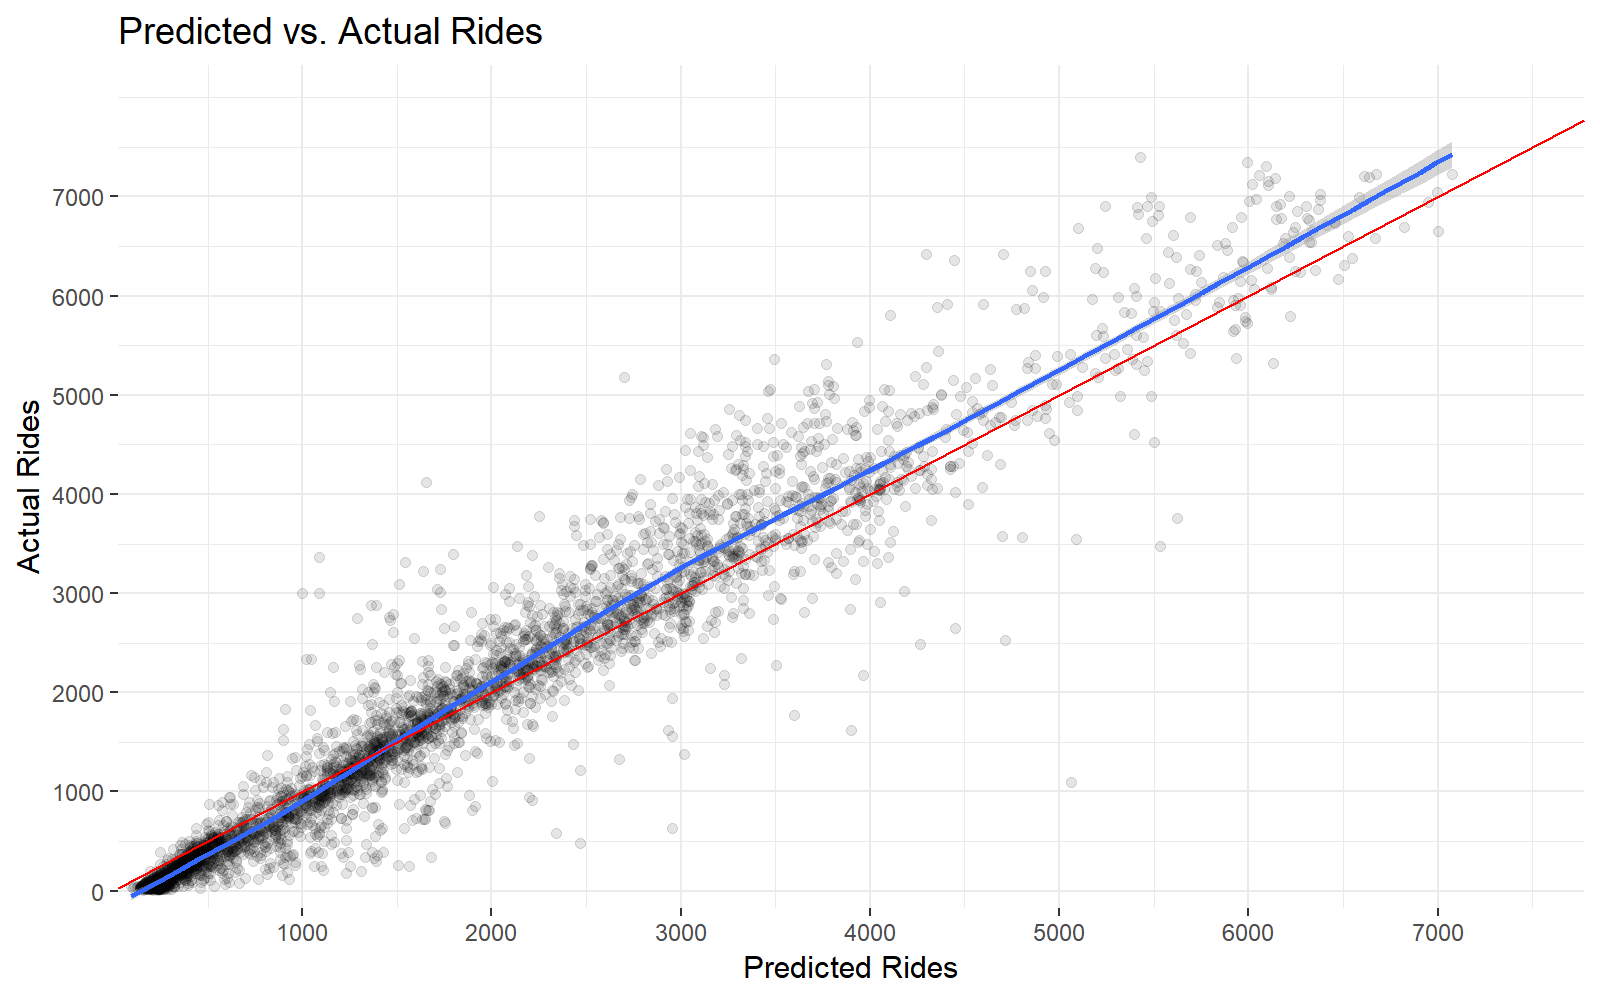

In [50]:
%%R -i explore -w 8 -h 5 --units in -r 200
explore %>%
  ggplot(aes(preds, rides)) +
  geom_point(alpha=0.1) +
  geom_smooth() +
  geom_abline(slope=1, intercept=0, color='red') +
  labs(x='Predicted Rides',
       y='Actual Rides',
       title='Predicted vs. Actual Rides') + 
  scale_x_continuous(labels=seq(0, 7000, 1000), breaks=seq(0, 7000, 1000), expand=c(0.01, 0.1, 0.1, 0)) +
  scale_y_continuous(labels=seq(0, 7000, 1000), breaks=seq(0, 7000, 1000), expand=c(0.01, 0.1, 0.1, 0)) +
  theme_bw() +
  theme(panel.border = element_blank())
  

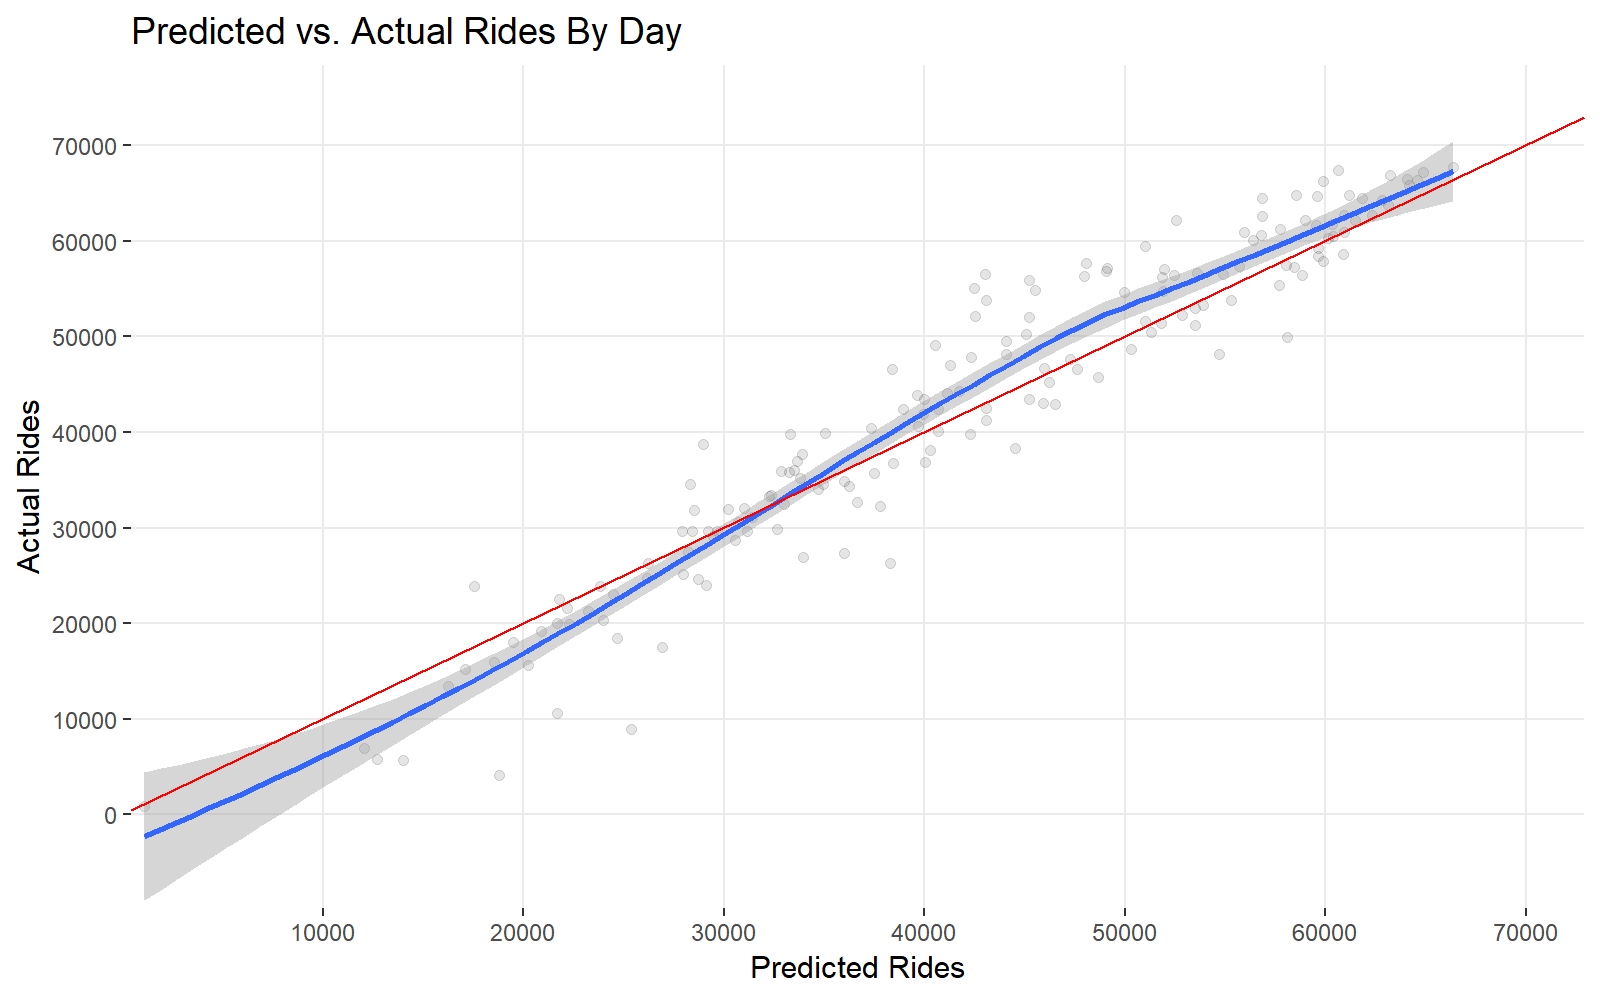

In [62]:
%%R -i explore -w 8 -h 5 --units in -r 200
explore %>%
  group_by(date) %>%
  summarize(preds = sum(preds),
            rides = sum(rides)) %>%
  ggplot(aes(preds, rides)) +
  geom_point(alpha=0.1) +
  geom_smooth() +
  geom_abline(slope=1, intercept=0, color='red') +
  labs(x='Predicted Rides',
       y='Actual Rides',
       title='Predicted vs. Actual Rides By Day') + 
  scale_x_continuous(labels=seq(0, 70000, 10000), breaks=seq(0, 70000, 10000), expand=c(0.01, 0.1, 0.1, 0)) +
  scale_y_continuous(labels=seq(0, 70000, 10000), breaks=seq(0, 70000, 10000), expand=c(0.01, 0.1, 0.1, 0)) +
  theme_bw() +
  theme(panel.border = element_blank(),
        panel.grid.minor = element_blank())
  

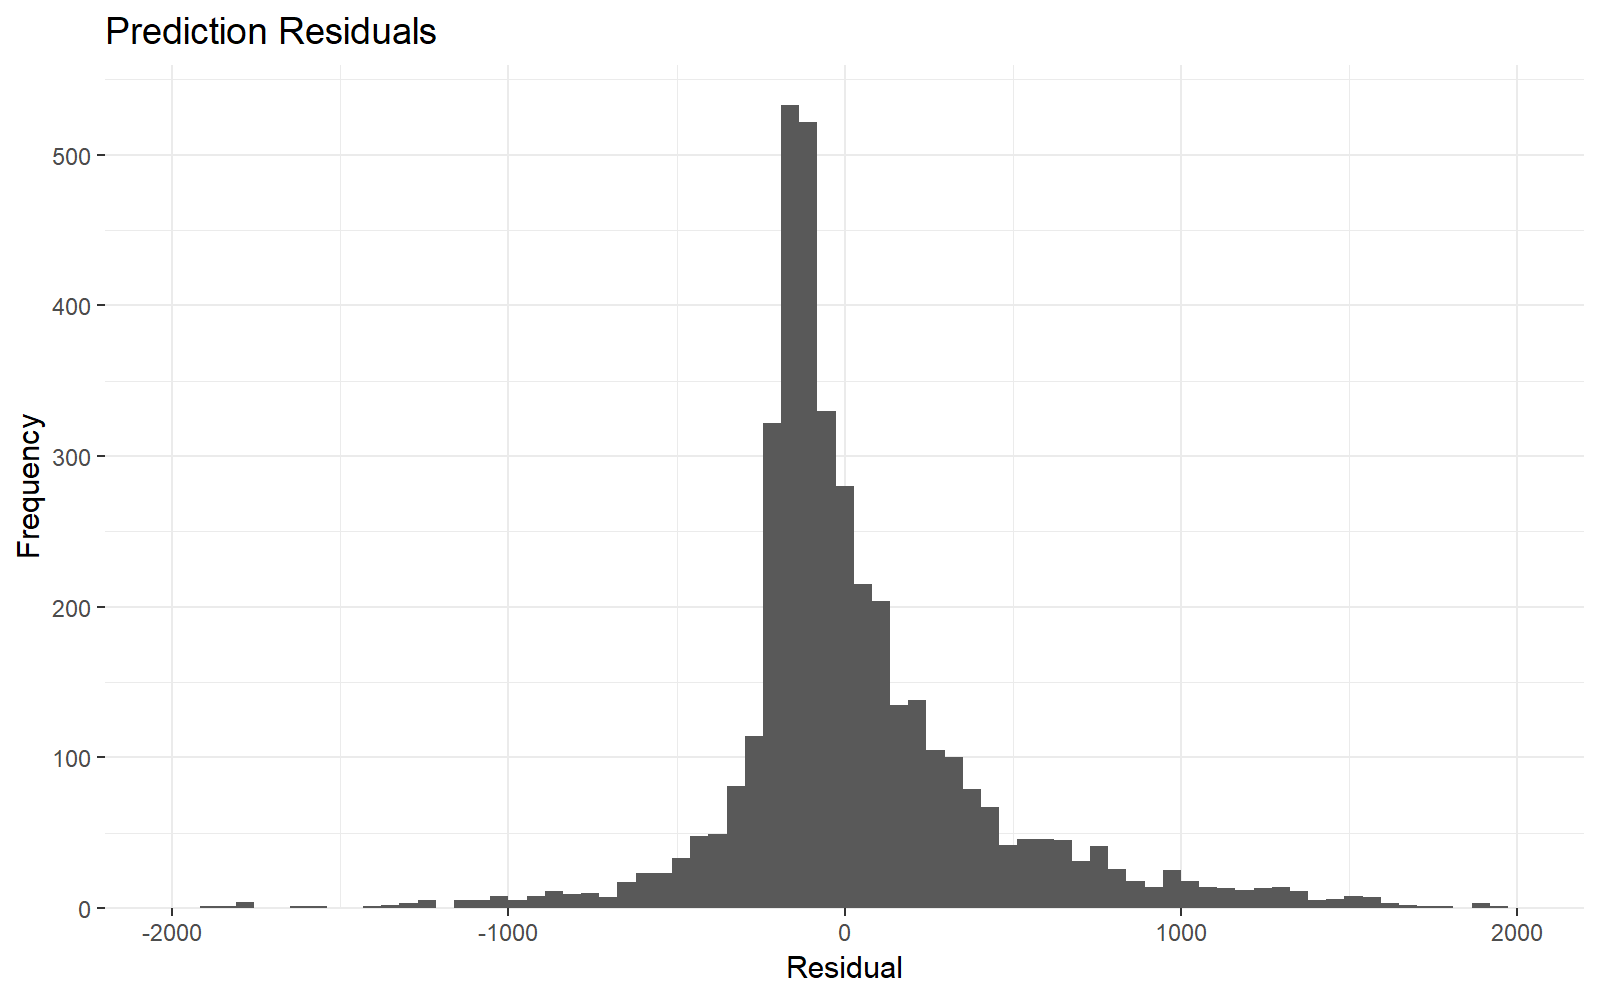

In [76]:
%%R -i explore -w 8 -h 5 --units in -r 200
explore %>%
  mutate(resid = rides - preds) %>%
  ggplot(aes(resid)) +
  geom_histogram(bins=75) +
  labs(x='Residual',
       y='Frequency',
       title='Prediction Residuals') +
  scale_x_continuous(labels=seq(-2000, 2000, 500), breaks=seq(-2000, 2000, 500), expand=c(0.01, 0.1, 0.1, 0)) +
  scale_y_continuous(expand=c(0, 0, 0.05, 0)) +
  xlim(-2000, 2000) +
  theme_bw() +
  theme(panel.border = element_blank())
  